In [19]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from skimage.feature import hog
from scipy import ndimage
from skimage.transform import resize

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

## Load Data

In [103]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=1/7.0, random_state=0)

## Tiền xử lí (crop + (resize + hog))

In [20]:
# Loại bỏ các điểm ảnh ở biên (giá trị 0)
def crop(data):
    data = data.reshape(28,28)
    r = data[~np.all(data == 0, axis=1)] # loại bỏ hàng toàn 0
    idx = np.argwhere(np.all(r[..., :] == 0, axis=0)) # vị trí cột toàn 0
    c = np.delete(r, idx, axis=1) # loại bỏ cột toàn 0
    res = cv2.resize(c, dsize=(28, 28)) # Trả lại về size 28x28
    res = res.flatten() # Chuyển lại thành array 1 chiều như ban đầu
    return res

In [21]:
def cropData(data):
    return np.apply_along_axis(crop, 1, data)

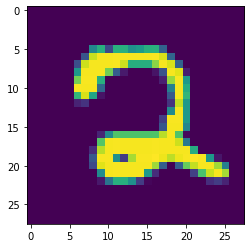

In [6]:
img = X_train[4].reshape(28,28,1)
plt.imshow(img);

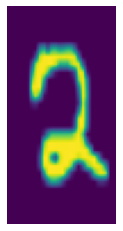

In [7]:
from skimage.transform import resize
resized_img = resize(img, (24*4, 12*4))
plt.axis("off")
plt.imshow(resized_img);

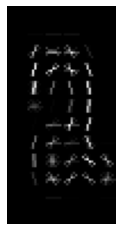

In [8]:
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray");

In [22]:
def Hog(data):
    img = data.reshape(28,28,1)
    resized_img = resize(img, (24*4, 12*4))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd

In [23]:
def HogData(data):
    return np.apply_along_axis(Hog, 1, data)

## Pipeline

In [11]:
preprocess_pipeline = make_pipeline(FunctionTransformer(cropData),
                                    FunctionTransformer(HogData),
                                    StandardScaler())

In [12]:
start = time.time()
X_train_tf = preprocess_pipeline.fit_transform(X_train)
X_test_tf = preprocess_pipeline.transform(X_test)
end = time.time()

print('Time to transform model: {}s'.format(end-start))

Time to transform model: 3255.328389644623s


In [13]:
import pickle
filename = 'preprcess.sav'
pickle.dump(preprocess_pipeline, open(filename, 'wb'))

In [105]:
#test
preprocess_pipeline = pickle.load(open('preprcess.sav', 'rb'))
X_test_tf = preprocess_pipeline.transform(X_test)
preds_test_crop = loaded_model.predict(X_test_tf)
print('Test Error: {} %\n'.format(np.mean(preds_test_crop != y_test)*100))

Test Error: 2.27 %



In [14]:
start = time.time()
logreg_crop_model = LogisticRegression().fit(X_train_tf, y_train)
end = time.time()

print('Time to fit model: {}s'.format(end-start))

Time to fit model: 176.67657160758972s


D:\App\New folder (3)\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# save the model to disk
import pickle
filename = 'hog_model.sav'
pickle.dump(logreg_crop_model, open(filename, 'wb'))

In [16]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

preds_train_crop = loaded_model.predict(X_train_tf)
preds_test_crop = loaded_model.predict(X_test_tf)

# Evaluation
print('Train Error: {} %'.format(np.mean(preds_train_crop != y_train)*100))
print('Test Error: {} %\n'.format(np.mean(preds_test_crop != y_test)*100))

Train Error: 0.0 %
Test Error: 2.27 %



## Mô hình cuối cùng
* *preprcess.sav* tiền xử lý (lưu ý đầu vào có kiểu 'float64')
* *hog_model.sav* mô hình LR fit với train.
* *hog_model_final.sav* mô hình đã fit với toàn bộ MNIST data.

## Tập Test mới

In [117]:
newdata = pd.read_csv('newtest.csv',names = np.arange(0,785).astype('str'))
newdata.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
new_test_x = newdata.drop('784',axis = 1).astype('float64')
new_test_Y = newdata['784'].astype('str')

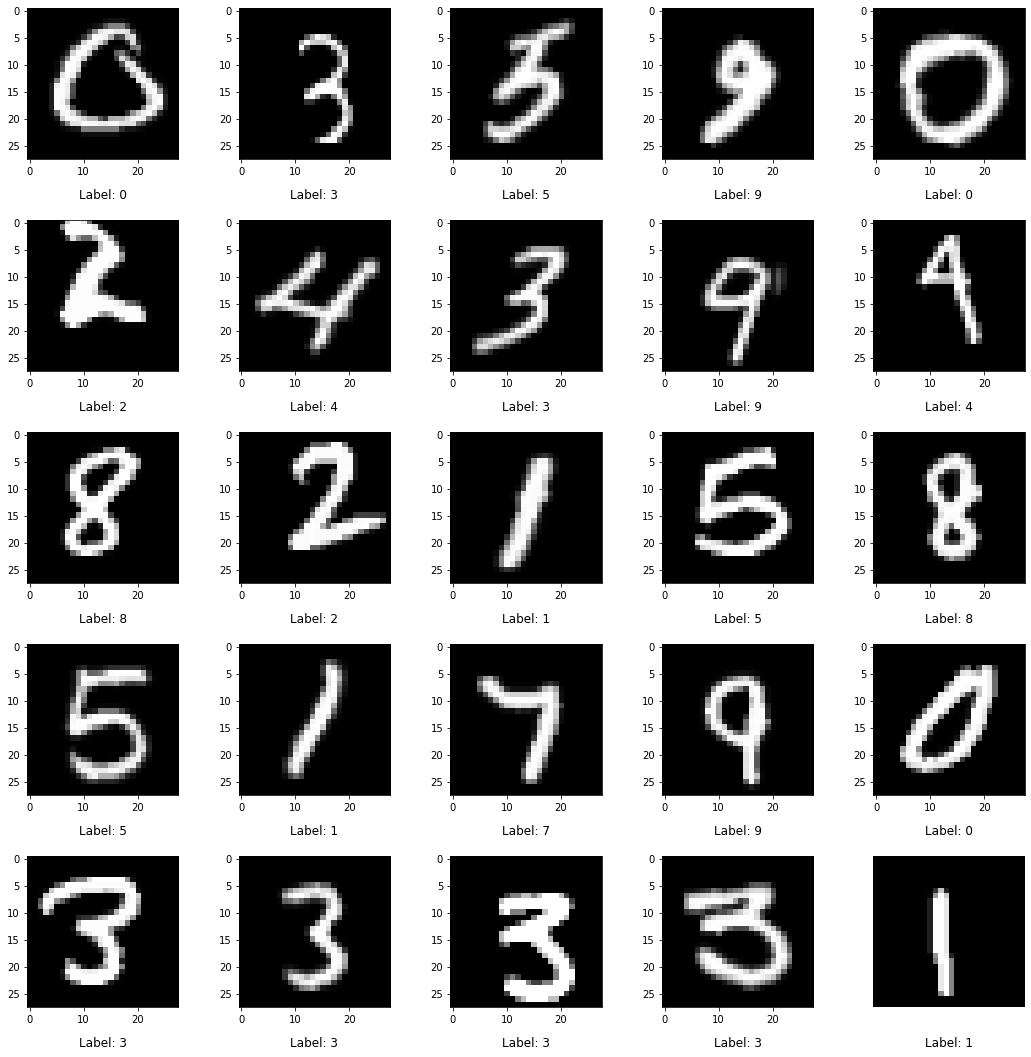

In [120]:
from numpy.random import randint
pos = randint(0,10000,25)
pos = pos.reshape(5,5)

fig, ax = plt.subplots(5,5,figsize = (15,15))
plt.axis("off")
for i in range (5):
    for j in range(5):
        ax[i][j].imshow(np.array(new_test_x.loc[pos[i][j],:]).reshape(28,28),cmap=plt.get_cmap('gray'))
        ax[i][j].set_title("Label: %s" % (new_test_Y[pos[i][j]]), y = -0.3)
fig.tight_layout(pad=2.0)

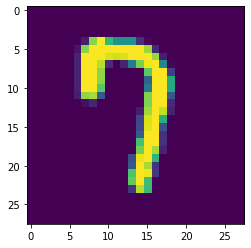

In [121]:
img = np.array(new_test_x.loc[1,:]).reshape(28,28,1)
plt.imshow(img);

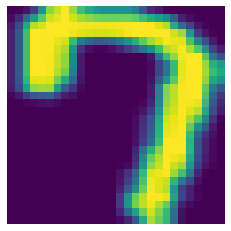

In [84]:
crop_data = crop(img)
plt.axis("off")
plt.imshow(crop_data.reshape(28,28));

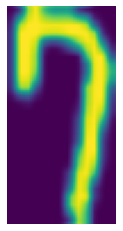

In [89]:
from skimage.transform import resize
resized_img = resize(crop_data.reshape(28,28), (24*4, 12*4,1))
plt.axis("off")
plt.imshow(resized_img);

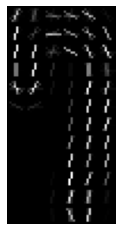

In [90]:
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray");

In [122]:
preprocess_pipeline = pickle.load(open('preprcess.sav', 'rb'))
loaded_model = pickle.load(open('hog_model_final.sav', 'rb'))

In [123]:
after_new_test_x = preprocess_pipeline.transform(new_test_x)
preds_new_test = loaded_model.predict(after_new_test_x)

In [133]:
# Evaluation
print('Test Error: {} %\n'.format(np.mean(preds_new_test  != new_test_Y)*100))

Test Error: 2.48 %



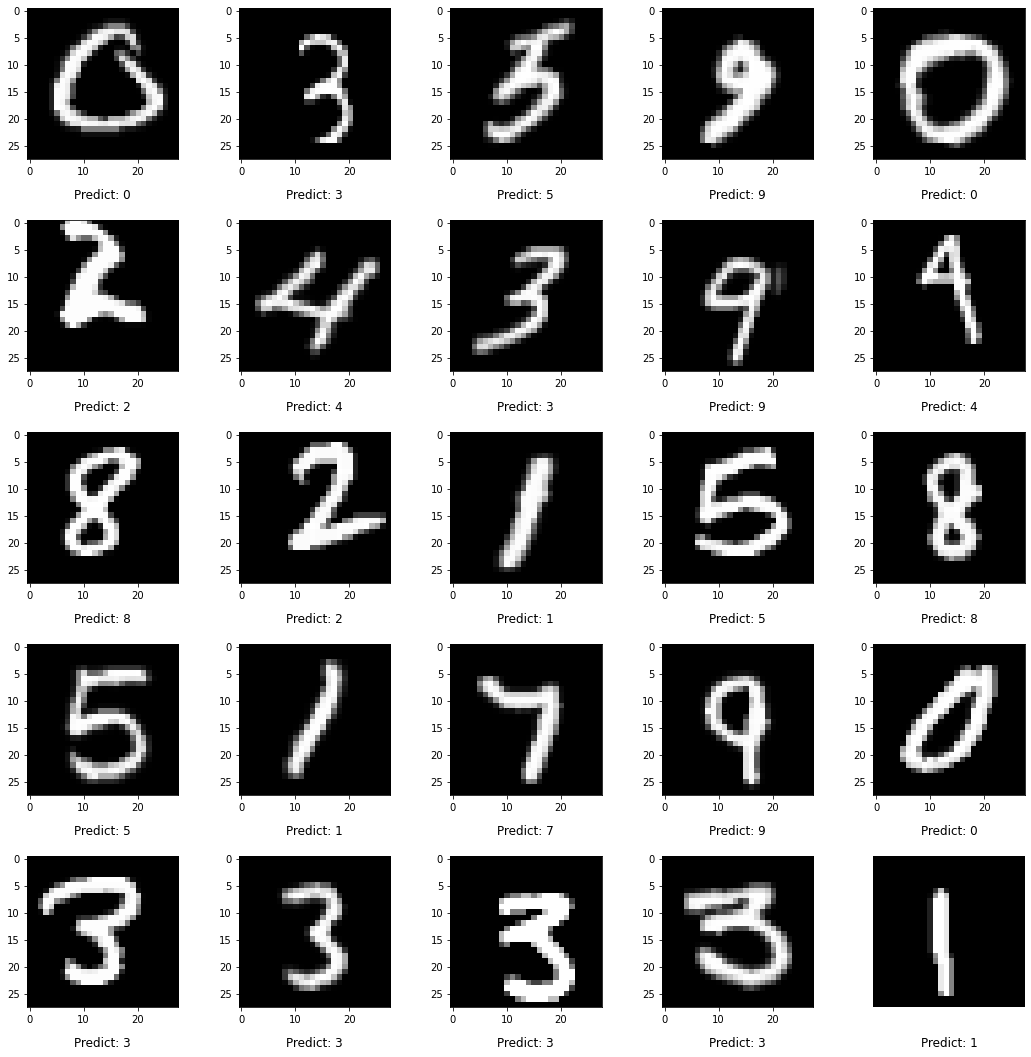

In [125]:
fig, ax = plt.subplots(5,5,figsize = (15,15))
plt.axis("off")
for i in range (5):
    for j in range(5):
        ax[i][j].imshow(np.array(new_test_x.loc[pos[i][j],:]).reshape(28,28),cmap=plt.get_cmap('gray'))
        ax[i][j].set_title("Predict: %s" % (preds_new_test[pos[i][j]]), y = -0.3)
fig.tight_layout(pad=2.0)